In [184]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import numpy as np
import re
import pandas as pd
import string
from pandarallel import pandarallel
import typing
from scipy import sparse

pandarallel.initialize()
nltk.download("stopwords")
nltk.download("punkt")

%load_ext line_profiler


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mansmooth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mansmooth/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
def create_stem_cache(cleaned_description: pd.DataFrame):
    tokenized_description = cleaned_description.parallel_apply(
        lambda s: word_tokenize(s)
    )
    concated: np.ndarray = pd.unique(tokenized_description.explode())
    ps = PorterStemmer()
    stem_cache = {}
    for s in concated:
        stem_cache[s] = ps.stem(s)
    return stem_cache


def create_custom_preprocessor(stop_dict: set[str], stem_cache):
    def custom_preprocessor(s):
        ps = PorterStemmer()
        s = re.sub(r"[^A-Za-z]", " ", s)
        s = re.sub(r"\s+", " ", s)
        s = word_tokenize(s)
        s = set(s).difference(stop_dict)
        s = [word for word in s if len(word) > 2]
        s = [stem_cache[w] if w in stem_cache else ps.stem(w) for w in s]
        s = " ".join(s)
        return s

    return custom_preprocessor


def sk_vectorize(texts, cleaned_description, stop_dict, stem_cache):
    my_custom_preprocessor = create_custom_preprocessor(stop_dict, stem_cache)
    vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor)
    vectorizer.fit(cleaned_description)
    query = vectorizer.transform(texts)
    print(query)
    print(vectorizer.inverse_transform(query))


def extract_description(df: pd.DataFrame):
    s = df["job_description"]
    s = s.parallel_apply(
        lambda s: s.lower()
        .translate(str.maketrans("", "", string.punctuation + "\xa0"))
        .translate(str.maketrans(string.whitespace, " " * len(string.whitespace)))
    )
    return s


# 39-42 tf-idf

In [12]:
import itertools

arr_idx = np.array(["DevOpsHandbook", "ContinuousDelivery", "DistributedComputing"])
arr = np.array([[100, 200, 200, 50], [90, 200, 300, 0], [5, 200, 10, 200]])

data = pd.DataFrame(
    arr,
    index=arr_idx,
    columns=["business", "computer", "git", "parallel"],
)
data = np.log10(data + 1)

for combi in itertools.combinations(arr_idx, 2):
    print(f"{combi[0]}.{combi[1]}: {data.loc[combi[0]].dot(data.loc[combi[1]])}")


DevOpsHandbook.ContinuousDelivery: 14.939885194377617
DevOpsHandbook.DistributedComputing: 13.195777686137449
ContinuousDelivery.DistributedComputing: 9.410303606094942


In [6]:
data.loc['DevOpsHandbook'] /= np.sqrt((data.loc['DevOpsHandbook'] ** 2).sum())
data.loc['ContinuousDelivery'] /= np.sqrt((data.loc['ContinuousDelivery'] ** 2).sum())
data.loc['DistributedComputing'] /= np.sqrt((data.loc['DistributedComputing'] ** 2).sum())
data


,business,computer,git,parallel
DevOpsHandbook,0.478543,0.549901,0.549901,0.407692
ContinuousDelivery,0.501071,0.589096,0.633951,0.000000
DistributedComputing,0.221882,0.656732,0.296942,0.656732


In [13]:
for combi in itertools.combinations(arr_idx, 2):
    print(f"{combi[0]}.{combi[1]}: {data.loc[combi[0]].dot(data.loc[combi[1]])}")


DevOpsHandbook.ContinuousDelivery: 14.939885194377617
DevOpsHandbook.DistributedComputing: 13.195777686137449
ContinuousDelivery.DistributedComputing: 9.410303606094942


In [170]:
m1 = pd.read_csv("./resources/software_developer_united_states_1971_20191023_1.csv")
cleaned_description = extract_description(m1)
cleaned_description.drop_duplicates(inplace=True)
cleaned_description.reset_index(drop=True, inplace=True)
stem_cache = create_stem_cache(cleaned_description)
stop_dict = set(stopwords.words("english"))


In [171]:
my_custom_preprocessor = create_custom_preprocessor(stop_dict, stem_cache)
tf_idf_vectorizer = TfidfVectorizer(preprocessor=my_custom_preprocessor, use_idf=True)
vector_tf_idf = tf_idf_vectorizer.fit_transform(cleaned_description)
vector_vocab = tf_idf_vectorizer.get_feature_names_out()
vector_tf_idf


<7582x30513 sparse matrix of type '<class 'numpy.float64'>'
	with 1379684 stored elements in Compressed Sparse Row format>

In [172]:
my_custom_preprocessor = create_custom_preprocessor(stop_dict, stem_cache)
count_vectorizer = CountVectorizer(preprocessor=my_custom_preprocessor)
count_X: sparse.csr_matrix = count_vectorizer.fit_transform(cleaned_description)
count_vocab = tf_idf_vectorizer.get_feature_names_out()


def log10_1p(x: np.matrix[any, any]) -> np.matrix[any, any]:
    return np.log1p(x) / np.log(10)


N = len(cleaned_description)

df = count_X.sum(axis=0)
idf = log10_1p((N / df))
tf = log10_1p(count_X)

count_tf_idf: sparse.coo_matrix = tf.multiply(idf)
count_tf_idf


<7582x30513 sparse matrix of type '<class 'numpy.float64'>'
	with 1379684 stored elements in COOrdinate format>

# 43 Search

In [196]:
def search(terms: str, tf_idf: np.matrix, vectorizer) -> pd.Series:
    Q = vectorizer.transform([terms])
    cos_sim = cosine_similarity(tf_idf, Q, dense_output=False)
    df = (
        pd.DataFrame.sparse.from_spmatrix(cos_sim, columns=["score"])
        .sort_values("score", ascending=False)
    )
    df["description"] = df.parallel_apply(lambda x: cleaned_description.loc[x.index])
    return df


In [197]:
search("aws devops", count_tf_idf, count_vectorizer).head(5)


,score,description
2980,0.243932,experience with java aws spring or spring boot...
4014,0.157274,sr software developer tssci reston va 150k a g...
2180,0.133551,washington dc devopssoftware developer locati...
2395,0.133551,washington dc devopssoftware developer locati...
513,0.130424,required skills very strong experience in php ...


In [198]:
search("aws devops", vector_tf_idf, tf_idf_vectorizer).head(5)


,score,description
2980,0.227109,experience with java aws spring or spring boot...
4014,0.161257,sr software developer tssci reston va 150k a g...
513,0.153905,required skills very strong experience in php ...
2180,0.151060,washington dc devopssoftware developer locati...
2395,0.151060,washington dc devopssoftware developer locati...


# 80, 86, 87 BM25

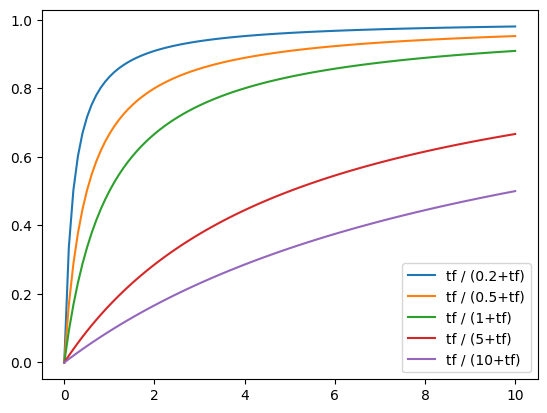

In [202]:
import matplotlib.pyplot as plt
tf = np.linspace(0, 10, 100)
for k in [0.2, 0.5, 1, 5, 10]:
    plt.plot(tf, tf / (k+tf), label="tf / ("+str(k)+"+tf)")
plt.legend()
plt.show()


In [203]:
class BM25(object):
    def __init__(self, vectorizer, b=0.75, k1=1.6):
        self.vectorizer = vectorizer
        self.b = b
        self.k1 = k1

    def fit(self, X):
        """Fit IDF to documents X"""
        self.vectorizer.fit(X)
        self.y = super(TfidfVectorizer, self.vectorizer).transform(X)
        self.avdl = self.y.sum(1).mean()

    def transform(self, q):
        """Calculate BM25 between query q and documents X"""
        b, k1, avdl = self.b, self.k1, self.avdl

        # apply CountVectorizer
        len_y = self.y.sum(1).A1
        (q,) = super(TfidfVectorizer, self.vectorizer).transform([q])
        assert sparse.isspmatrix_csr(q)

        # convert to csc for better column slicing
        y = self.y.tocsc()[:, q.indices]
        denom = y + (k1 * (1 - b + b * len_y / avdl))[:, None]
        idf = self.vectorizer._tfidf.idf_[None, q.indices] - 1.0
        numer = y.multiply(np.broadcast_to(idf, y.shape)) * (k1 + 1)
        return (numer / denom).sum(1).A1


In [205]:
m1 = pd.read_csv("./resources/software_developer_united_states_1971_20191023_1.csv")
cleaned_description = extract_description(m1)
cleaned_description.drop_duplicates(inplace=True)
cleaned_description.reset_index(drop=True, inplace=True)
bm25 = BM25(tf_idf_vectorizer)
bm25.fit(cleaned_description)


In [218]:
pd.set_option('max_colwidth', 500)
score = bm25.transform("aws devops")
rank = np.argsort(score)[::-1]
cleaned_description.iloc[rank[:5]]


2395    washington dc  devopssoftware developer location downtown washington dc 2 days remote flex my client in downtown washington dc is looking to hire a devopssoftware developer asap you will be collecting data that they are fetching and downloading it for multiple projects for various partners you will be working on the devops side of things but big data experience is a plus this person will have the opportunity to eventually move into a lead role and help manage the head of devops and integrati...
2180    washington dc  devopssoftware developer location downtown washington dc my client in downtown washington dc is looking to hire a devopssoftware developer asap you will be collecting data that they are fetching and downloading it for multiple projects for various partners you will be working on the devops side of things but big data experience is a plus this person will have the opportunity to eventually move into a lead role and help manage the head of devops and integration pref

In [219]:
score = bm25.transform("aws github")
rank = np.argsort(score)[::-1]
cleaned_description.iloc[rank[:5]]


7037    software developer  reston virginia software developer  reston virginia  full time are you interested in making a difference and playing a large role in protecting your country take advantage of an awesome opportunity to join a highlyskilled team of developers and work on an exciting project where you will be serving your country at an extremely high level you will be carrying out a critical mission to protect the health and safety of americans from newage posed threatsmy exclusive client is...
4590    we are currently seeking a full stack net developer to join the team to be involved in all aspects of the software development lifecycle building aspnet web applications including mvc c javascript jquery and css the ideal candidates will also have strong experiencedeveloping sql server schemas queries and stored procedures this individual will work as a team member of architects developers and qa personnel in a professional yet relaxed and flexible environment  qualification  bac